In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.optimize import brentq

In [2]:
class Aiyagari:

    def __init__(self, n_a = 80, n_l = 19, α = 0.4, γ = 2, δ =1, ρ = 0.95, β = 0.96
                     , σ = 0.0645, θ = 1.5, A_min = 0, A_max = 4,   error = 10e-6, max_iter = 1000, N=100, T=10000):

        self.n_a = n_a                 # Grids for Assets.
        self.n_l = n_l                 # Markov States or labor.
        self.α = α                     # Capital Share.
        self.ρ = ρ                     # Memory of labor (Standard deviation).
        self.σ = σ                     # Volatility of labor .
        self.δ = δ                     # Depreciation.
        self.β = β                     # Discont factor.
        self.θ = θ                     # Expanding grid parameter.
        self.error = 10e-6             # Error tolerance.
        self.max_iter = 1000           # Max iterations.
        self.A_min = A_min             # Minimum assets.
        self.A_max = A_max             # Maximum assets.
        self.N = N                     # Number of agents in simulation
        self.T = T                     # Number of periods in simulation
        λ = (1-β)/β                    # Impatience parameter.
       
        # Create the transition matrix:
        # Element (i,j) is the probability of being in state l_i and going to l_j.
        # Each row gives the probability of switching states given where we are
        
        markov = qe.markov.approximation.rouwenhorst(n = n_l, ybar = 0, sigma = σ, rho= ρ)

        self.Π = markov.P   
        for n in range(1000):
            if n == 0:
                self.π =  self.Π[0,:].copy()
            else:
                self.π = self.π @ self.Π
        self.π = self.π

        # Create the vector for income shocks:
        # Compute the stationary demand supply:

        self.L = np.exp(markov.state_values)
        self.L_bar = self.π @ self.L
        self.A = A_min + (A_max - A_min) * (np.linspace(0, 1, n_a)**θ)
        self.K_min = (((λ + 1)/α)**(1/(α-1))) * self.L_bar # Minimum Capital Demand possible to ensure βR <= 1

        
        self.params = n_a, n_l, α, δ, β, γ, self.L_bar, A_min, A_max
        self.grids = self.Π, self.π, self.A, self.L

In [3]:
# Utility function
def U(c, γ):
    return (1/(1-γ)) * ((c)**(1-γ))

In [4]:
# def VFI_Agent(model, K):

#     # Unload parameters:
#     error = model.error 
#     max_iter = model.max_iter
#     n_a, n_l, α, δ, β, γ, L_bar, A_min, A_max = model.params
#     Π, π, A, L = model.grids

#     # Aux. variables:
#     iter = 0
#     bounds_A = scipy.optimize.Bounds(A[0], A[-1])

#     # Prices:
#     r_k = α * (K/L_bar)**(α-1)    
#     w = (1-α) * (K/L_bar)**(α)
#     r = r_k - δ

#     # Initial value function.
#     # We need something increasing and concave therefore we can use U(z[i,j]):
#     V_0 = np.empty((n_l, n_a), dtype = float)
#     V_1 = np.empty((n_l, n_a), dtype = float)

#     for i in range(n_l):
#         z = w * L[i] + (1 + r) * A
#         V_0[i,:] = U(z, γ) 

#     # Policy for assets: 
#     h_0 = np.ones((n_l, n_a), dtype=float) * 0.5
#     h_1 = h_0.copy()

#     while iter < max_iter:

#         for i in range(n_l):

#             # Interpolate the value function given income realization:

#             E_V = CubicSpline(A, Π[i,:] @ V_0 , bc_type="natural")

#             for j in range(n_a):

#                 # Given labor income and assets wealth is given by:

#                 z = w * L[i] + (1 + r) * A[j]

#                 # return function:

#                 def R(x):
#                     return -(U(z - x, γ) + β * E_V(x))

#                 h_1[i, j] = scipy.optimize.minimize(R, 0, tol = error, method = 'SLSQP', bounds = bounds_A).x[0]
#                 V_1[i,j] = (U(z - h_1[i, j], γ) + β * E_V(h_1[i, j]))


#         if np.amax(np.abs((h_1 - h_0)/(1 + np.abs(h_0)))) < error:

#             print("Solution Found")
#             print(f'Iterations', iter)
#             print(f'Error', np.amax((h_1 - h_0)/(1 + np.abs(h_0))))
#             break
        
#         else:
#             iter += 1
#             if iter % 100 == 0:
#                 print("Entering iteration")
#                 print(iter)
#                 print("Error")
#                 print('{0:.16f}'.format(np.amax((h_1 - h_0)/(1 + np.abs(h_0)))))
#             if iter >= max_iter:
#                 print("No solution")

#             V_0 = np.copy(V_1)
#             h_0 = np.copy(h_1)

#     return V_1, h_1    

In [4]:
def VFI_Agent(model, K):

    # Unload parameters:

    error = model.error 
    max_iter = model.max_iter
    n_a, n_l, α, δ, β, γ, L_bar, A_min, A_max = model.params
    Π, π, A, L = model.grids

    # Aux. variables:

    iter = 0
    bounds_A = scipy.optimize.Bounds(A[0], A[-1])

    # Prices:

    r_k = α * (K/L_bar)**(α-1)
    r = r_k - δ
    w = (1-α) * (K)**(α) * (L_bar)**(-α)

    # Initial conditions:

    # Initial value function.
    # We need something increasing and concave therefore we can use U(z[i,j]):
    V_0 = np.empty((n_l, n_a), dtype = float)
    V_1 = np.empty((n_l, n_a), dtype = float)

    for i in range(n_l):

        z = w * L[i] + (1 + r) * A
        V_0[i,:] = U(z, γ) 

    # Policy for assets: 

    h_0 = np.zeros((n_l, n_a), dtype=float)
    h_1 = h_0.copy()
   
    iter = 0

    while iter < max_iter:

        for i in range(n_l):
            # Interpolate the value function given income realization:
            E_V  = scipy.interpolate.PchipInterpolator(A, Π[i,:] @ V_0, extrapolate = True)
            for j in range(n_a):
                # Given labor income and assets wealth is given by:
                z = w * L[i] + (1 + r) * A[j]
                # return function:
                def R(x):
                    return -(U(z - x, γ) + β * E_V(x))  
                bounds_A = scipy.optimize.Bounds(A[0], np.minimum(z, A[-1])) 
                x_0 = 0.5 * (A[0]+np.minimum(z, A[-1]))         
                h_1[i, j] = scipy.optimize.minimize(R, x_0, tol = error, method = 'SLSQP', bounds = bounds_A).x[0]
                V_1[i,j] = (U(z - h_1[i, j], γ) + β * E_V(h_1[i, j]))
            
        error_i = np.amax(np.abs((h_1 - h_0)/(1 + np.abs(h_0))))

        if error_i < error:

            print("Solution Found")
            print(f'Iterations', iter)
            print(f'Error', error_i)
            break
        
        else:
            if iter % 100 == 0:
                print("Entering iteration")
                print(iter)
                print("Error")
                print('{0:.16f}'.format(error_i))
                
            V_0 = np.copy(V_1)
            h_0 = np.copy(h_1)
            iter += 1
            if iter >= max_iter:
                print("No solution")

    return V_1, h_1    

In [5]:
def simulation(Model, Income_sim, h, seed=1234):
    np.random.seed(seed)
    A, N, T, n_l, n_a = Model.A, Model.N, Model.T, Model.n_l, Model.n_a

    K_sim = np.zeros((N,T+1))
    K_sim[:,0] = A[-1]/2

    lin_interpolations = []
    for i in range(n_l):
        lin_interpolations.append(interp1d(A, h[i,:]))

    for n in range(N):
        for t in range(T):         
            #Given income shock find the policy simulation
            K_sim[n,t+1] = lin_interpolations[Income_sim[n,t]](K_sim[n,t])
   
    # Capital Supply
    Ks = np.sum(K_sim[:,-1])/N
    
    return Income_sim, K_sim, Ks
  

In [16]:
def equilibrium(Model, K_init = 1.3, tol = 10e-6, max_iter = 1000): 
    # Shock simulations for N agents in T periods
    Income_sim = np.random.choice(np.arange(0, Model.n_l), size = (Model.N,Model.T), p = Model.π)

    # Market Clearing Condition
    def MC(K):
        mc = simulation(Model, Income_sim, VFI_Agent(Model,K)[1])[2] - K
        print("Dist: ", mc)
        return mc

    K_eq = brentq(MC,a=Model.K_min, b=K_init) # Solve for K to clear the Market
    
    V_eq, h_eq = VFI_Agent(Model, K_eq)
    Income_sim, A_sim, Ks_eq = simulation(Model, h_eq)

    return K_eq, Ks_eq, V_eq, h_eq, Income_sim, A_sim, Ks_eq

In [17]:
Aiyagari_Model = Aiyagari()

In [18]:
equilibrium(Aiyagari_Model)

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_26066/2092108549.py:3: RuntimeWarning: invalid value encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


Entering iteration
0
Error
2.0505014359951019


/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_26066/2092108549.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


KeyboardInterrupt: 

In [12]:
v, h = VFI_Agent(Aiyagari_Model, 0.35)

/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_26066/2092108549.py:3: RuntimeWarning: invalid value encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


Entering iteration
0
Error
1.5918121756571091


/var/folders/c_/9slv16s13p50vtr162z5f8th0000gn/T/ipykernel_26066/2092108549.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return (1/(1-γ)) * ((c)**(1-γ))


Solution Found
Iterations 7
Error 3.030973686641022e-07


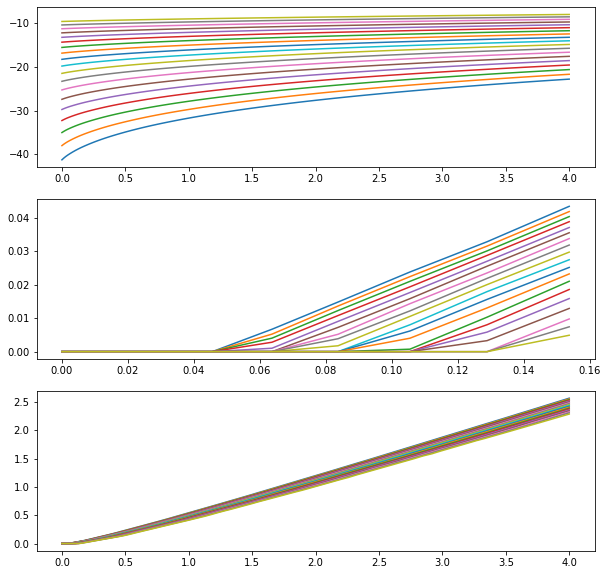

In [14]:
## Assets:

fig, ax  = plt.subplots(3, figsize=(10,10))
for i in range(Aiyagari_Model.n_l):
    ax[0].plot(Aiyagari_Model.A, v[i,:])
    ax[1].plot(Aiyagari_Model.A[0:10], h[i,:10])
    ax[2].plot(Aiyagari_Model.A, h[i,:])
plt.show()

In [97]:
income_sim, k_sim, ks = simulation(Model=Aiyagari_Model, h = h)

In [98]:
ks

4.0

In [87]:
h

array([[0.        , 0.        , 0.        , ..., 3.44849573, 3.63747072,
        3.83178389],
       [0.        , 0.        , 0.        , ..., 3.44982732, 3.63866713,
        3.83297146],
       [0.        , 0.        , 0.        , ..., 3.45136297, 3.64017837,
        3.8344172 ],
       ...,
       [0.0311126 , 0.03113162, 0.03126461, ..., 3.54565845, 3.73529203,
        3.93028945],
       [0.04401266, 0.04403114, 0.04416055, ..., 3.56174024, 3.75099799,
        3.94655815],
       [0.05928288, 0.05930161, 0.05943264, ..., 3.58002456, 3.76939731,
        3.96524697]])

In [88]:
k_sim[0,:]

array([2.00000000e+00, 1.89954029e+00, 1.81646469e+00, ...,
       0.00000000e+00, 0.00000000e+00, 6.00412935e-05])

In [76]:
income_sim

array([[ 7, 10,  9, ...,  7, 10, 11],
       [10,  9, 10, ..., 14, 14, 11],
       [ 9,  7,  8, ...,  7,  8, 10],
       ...,
       [ 5,  6, 10, ..., 10,  7,  9],
       [ 9,  7, 10, ..., 11,  6,  8],
       [ 9, 11,  9, ...,  9, 11,  6]])